# Agent based modelling of social systems

### Modelling social awereness through a cognitive architecture model
Questions/Topics : 
* What is our question(clear formulation)-> Global awereness
* Topology of network
* Network generator (random?)
* Interaction of agents
* Literature
* Assumptions

### Structure
* Output: Plot Magnitude of event vs Importance of agent (color:fraction of agents, prob. to pass threshold)
* Model: 
 * P(k) distribution of #of outward lines
 * Interaction as a weighted relation of importance of agent and magnitude of event)
* Network: 
 * Random neighbour selection
 * % of neighbours interaction in each time step
* Events
 * Prob. distribution of events log(magn)= $\beta$ - $\gamma$log(occurences)
 * Decay as an exponential function
 * Global magnitude state of each event

In [1]:
import numpy as np
import igraph
import matplotlib.pyplot as plt
from IPython.display import *
% matplotlib inline

In [9]:
class SocialNet:
    def __init__(self, N):
        """
        Initialize the Graph with N number of agents and 
        give them a number of connections(links) from a 
        power law distribution -> scale-free network. Adjust 
        the size of each vertex to represent the number of
        links it has.
        """
        self.N = N        
        self.g = igraph.Graph(self.N ,directed=True)
        self._create_agents() 
        self.visual_style = {}
        self.visual_style["vertex_size"]=self.g.vs["size"]
        self.visual_style["edge_arrow_size"] = 0.5
        
        # All events stored in this list! First event is the null-event. All agents start with that.
        self.events=[Event(magnitude=0)]
    
    def _create_agents(self):
        """Sets attributes of vertices in Graph g"""
        for v in self.g.vs:
            
            # Initialize with null-event
            v["event_id"]=0
            v["event_magnitude"]=0
            
            # Generate number of links and format vertex based on that
            links = self.scale_free_distr()
            v["size"] = 5 + 2*links
            v["links"] = links
            if links > 5:
                v["type"] = "core"
                v["color"] = "slate blue"
            else:
                v["type"] = "peripheral"
                v["color"] = "SeaGreen2"  
            
            # Create actual links between agents
            for link_id in range(links):
                source = v.index
                target = np.random.randint(0, len(self.g.vs))
                if not self.g.are_connected(source, target) and target!=source:
                    self.g.add_edge(source,target)
                self.g=self.g.simplify()
        return
    
    def scale_free_distr(self):
        """Power law distr P(k)=k^-2. In order to 
        limit the number of links possible distr is truncated
        at 0.001
        """
        p = np.random.rand()
        if p <= 0.001:
            return 1
        else:
            return int(np.round(1/np.sqrt(p)))
        
    def update(self):
        """Update all vertices by propagating the information and setting the new state"""
        
        # In each time-step events happen to agents.
        for v in self.g.vs:
            new_event = Event()
            # See whether new event is more interesting than old one
            if new_event.magnitude > v["event_magnitude"]:
                self.events.append(new_event)
                v["event_id"]=len(self.events)-1
                v["event_magnitude"]=new_event.magnitude       
        
        # In each time-step agents communicate.
        """ This part still needed!!! """
        
        # At the end of each time-step decay all events and update all vertice event magnitudes
        for single_event in self.events:
            single_event.decay()
            for v in self.g.vs:
                v["event_magnitude"]=self.events[v["event_id"]].magnitude
        pass
    
        
    def draw(self):        
        igraph.plot(self.g, "img/temp.png", **self.visual_style)
        display(Image(filename='img/temp.png')) 
        
    def displayPlot(self):
        plt.savefig("img/temp_plot.png")
        display(Image(filename='img/temp_plot.png'))

class Agent(igraph.Vertex):
    def __init__(self, name, num_links):
        self.attr = self.attributes()
        self.num_links = num_links
        self.visual_style["vertex_size"]=2*self.num_links
        self.visual_style["edge_arrow_size"] = 0.5
        self.event = 0
    def _create_links(self):
        pass
    def set_attributes(self):
        self.attr["size"] = int(self.num_links*2)
        
class Event:
    """ Single event. """
    def __init__(self,magnitude=None):
        # This part is so that if I don't give any value, then the magnitude is generated
        if magnitude==None:
            magnitude=np.random.power(a=0.02)
        self.magnitude=magnitude
    def decay(self):
        # keep dt=1 for now since we have discrete time-steps
        gamma=0.1
        dt=1
        self.magnitude=self.magnitude*(1-gamma*dt)

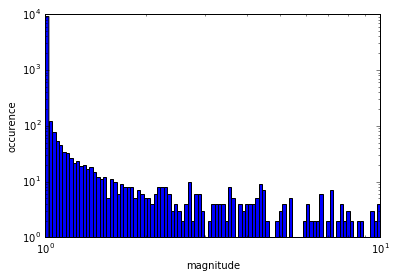

In [10]:
""" Just some playing with power lay and its plotting. """
x = 10**np.random.power(a=0.02,size=10000) 
# histogram with log-bining 
plt.hist(x, bins=10**np.linspace(0, 1, 100))
plt.yscale('log', nonposy='clip')
plt.xscale('log') 
plt.xlabel('magnitude')
plt.ylabel('occurence')
plt.show() 

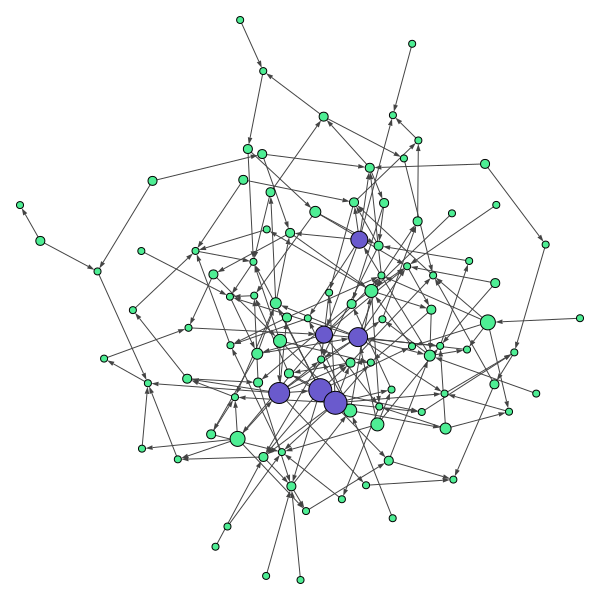

In [16]:
Net = SocialNet(100)
Net.draw()